In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import sys

import mlflow
import numpy as np
import scanpy as sc
import squidpy as sq

from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import download_nichenet_ligand_target_mx
from autotalker.utils import extract_gps_from_ligand_target_mx
from autotalker.utils import mask_adata_with_gp_dict

In [3]:
dataset = "squidpy_seqfish"

In [4]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv("datasets/seqFISH/counts.csv",
                                        "datasets/seqFISH/adj.csv")
    cell_type_key = None
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius = 0.04, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius = 30.0, coord_type="generic")
    cell_type_key = "cluster"

Using dataset squidpy_seqfish.


In [5]:
print(f"Number of nodes: {adata.X.shape[0]}")
print(f"Number of node features: {adata.X.shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 4.4
Number of edges: 42694


In [6]:
os.makedirs("mlruns", exist_ok=True)

In [7]:
experiment = mlflow.set_experiment("autotalker")
mlflow.log_param("dataset", dataset)

In [8]:
# Mask that allows all genes
mask = np.ones((16, len(adata.var)))

In [9]:
model = Autotalker(adata,
                   autotalker_module="VGPGAE",
                   n_hidden_encoder=32,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_mask=mask)

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
GCN ENCODER -> n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 16, n_output: 351


In [11]:
model.train(n_epochs=5,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            node_test_ratio=0.0,
            edge_batch_size=64,
            include_edge_recon_loss=True,
            include_gene_expr_recon_loss=True,
            mlflow_experiment_id=experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of test nodes: 0
Number of training edges: 36291
Number of validation edges: 4269
Number of test edges: 2134

--- MODEL TRAINING ---
Epoch 1/5 |████----------------| 20.0% val_auroc_score: 0.8767; val_auprc_score: 0.8438; val_best_acc_score: 0.8141; val_best_f1_score: 0.8342; train_loss: 278.9025; train_edge_recon_loss: 0.4431; train_kl_loss: 0.0275; train_gene_expr_recon_loss: 278.4319; val_loss: 274.6748; val_edge_recon_loss: 0.3552; val_kl_loss: 0.0292; val_gene_expr_recon_loss: 274.2904
Epoch 2/5 |████████------------| 40.0% val_auroc_score: 0.8627; val_auprc_score: 0.8282; val_best_acc_score: 0.7991; val_best_f1_score: 0.8205; train_loss: 273.9383; train_edge_recon_loss: 0.3386; train_kl_loss: 0.0262; train_gene_expr_recon_loss: 273.5736; val_loss: 273.5817; val_edge_recon_loss: 0.3347; val_kl_loss: 0.0237; val_gene_expr_recon_loss: 273.2233
Epoch 3/5 |████████████--------| 60.0% v

In [12]:
model.save(dir_path="./model_artefacts",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [13]:
model = Autotalker.load(dir_path="./model_artefacts",
                        adata=None,
                        adata_file_name="adata.h5ad")

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
GCN ENCODER -> n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 16, n_output: 351


In [14]:
latent = model.get_latent_representation()

In [15]:
latent_new_data = model.get_latent_representation(adata)

In [16]:
adata.obsm["latent_autotalker"] = latent_new_data

## Interoperability with scanpy

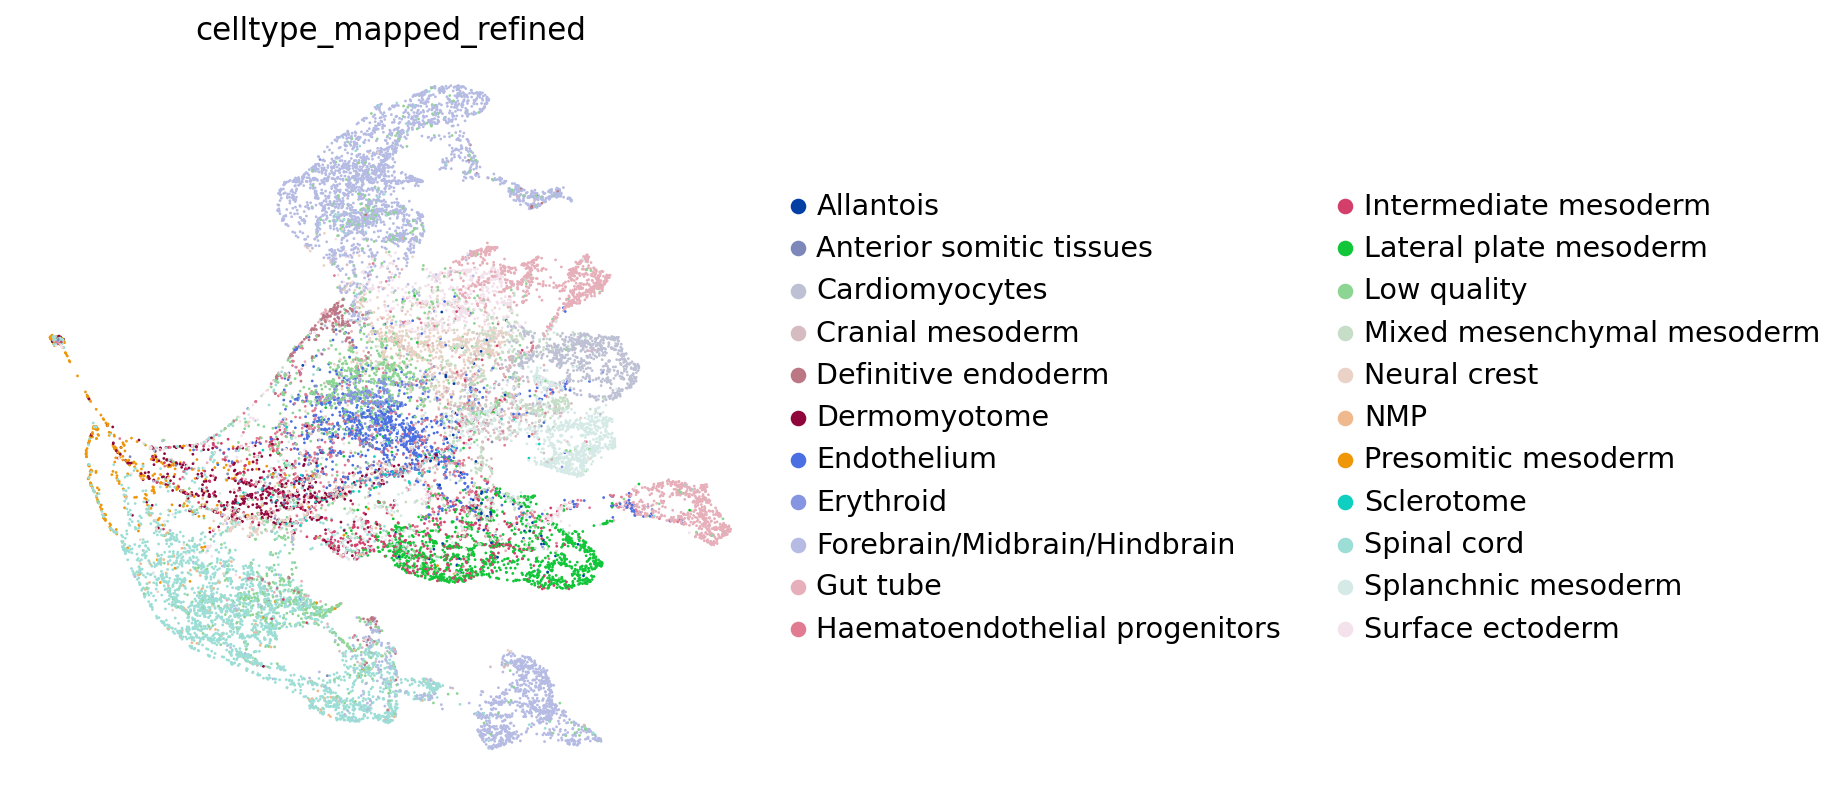

In [21]:
sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save="_latent.png")

## NicheNet Gene Programs (GPs)

In [ ]:
gp_data_folder_path = "datasets/gp_data"
gp_data_file_path = gp_data_folder_path + "/ligand_target_matrix.csv"
os.makedirs(gp_data_folder_path, exist_ok=True)

In [ ]:
download_nichenet_ligand_target_mx(
    save_path=gp_data_file_path)

In [ ]:
gp_dict = extract_gps_from_ligand_target_mx(
    path=gp_data_file_path)

In [ ]:
mask_adata_with_gp_dict(adata, gp_dict)

In [ ]:
mask = adata.varm["I"].T

In [ ]:
mask.shape

In [ ]:
mask.shape

In [ ]:
I = [[int(gene in gp) for _, gp in gp_dict.items()] for gene in adata_genes]
I = np.asarray(I, dtype="int32")

In [ ]:
gp_dict

In [ ]:
I.sum()

In [ ]:
for gp_name, gp in gp_dict.items():
    print(gp_name)
    print(gp)
    break

## SCVI

In [ ]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(6, 6))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts"
)

In [ ]:
model = scvi.model.SCVI(adata)

In [ ]:
model

In [ ]:
model.train()

In [ ]:
latent_scvi = model.get_latent_representation()

In [ ]:
adata.obsm["X_scVI"] = latent_scvi

In [ ]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.pl.umap(
    adata,
    color=["celltype_mapped_refined"],
    frameon=False,
)